# Introduction

This project focuses on implementing two different classifiers and make comparison between them. The classifiers employed in this project are both Naive Bayes models. We implement Bernoulli event model and Multonimial event model Naive Bayes classifiers for this project. The detailed implementation of both classifiers explained with detail in the Methods section. After implementing the Bernoulli and Multinomial Naive Bayes classifiers, we present the datasets we experimented on. Naive Bayes based classification models are based on some assumptions on the data, therefore the type of datasets we use would affect the accuracy of both models. Hence, we provide some information about the datasets in the following section to illuminate the behavior of classifiers.

# Methods

In this section, we provide detailed information about our classifiers and datasets. First we present the classifiers by explaining the Naive Bayes assumption and further building Bernoulli and Multinomial models on top of it. Both Bernoulli and Multinomial Naive Bayes classifiers explained following the base Naive Bayes implementation. Following the explanation of the classifiers, we show the datasets utilized in this project.

## Libraries

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
from time import time
from sklearn import datasets
from scipy.special import logsumexp
from sklearn.preprocessing import binarize, LabelBinarizer
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups

## Naive Bayes

Naive Bayes is a machine learning algorithm, more specifically, it is a classification method. This means that Naive Bayes is used when the output variable is discrete. The underlying methods of the algorithm are based on the Bayes Theorem that states:
$$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$
To make it easier to understand, this equation can be written using the features (attributes, input values) and the targets (output values). In simpler terms; this function can be employed to solve for the probability of $y$ with given features $X$ as:
$$P(y|X)=\frac{P(X|y)P(y)}{P(X)}$$
The Naive assumption takes place here on the formula. Naive Bayes method works on cases where different feature values are independent from each other. Therefore the formula can be rewritten as:
$$
P(X|y)=P(X_1|y)P(X_2|y)...P(X_n|y)
$$
It is clear that the goal is to solve for $y$, in this circumstance P(X) is a constant value and it can be removed from the equation. In addition to that, by implementing the proportional nature of the $X_1, X_2,...,X_n$ the equation can be presented as:
$$P(y|X)=P(y)\prod_{i=1}^nP(X_i|y)$$
Since the values across the datapoints can be calculated, the last step should be the finding the maximum of these calculated output values of $y$. The maximum can be obtained with the $\arg\max$ function:
$$
y = \arg\max_y[P(y)\prod_{i=1}^nP(X_i|y)]
$$
With taking consideration on provided information about Naive Bayes, the classification method can be explained as; first, create a frequency table and then a ratio table so that the values for P(X) and P(y|X) can be calculated, furthermore, for a given set of input features X, compute the proportionality of P(y|X) for each class y. In this example, the implementation should be binary or simply True or False output. Now as the last important part of the Naive Bayes method, there could be different assumptions when calculating $P(X|y)$ like Multinomial model, Bernoulli model and Gaussian model. This implementation focuses on Bernoulli and Multinomial models, each model are explained in detail in following subsection. Since both Bernoulli and Multinomial methods are based on Naive Bayes assumption, the code implementation structured accordingly. We presented a class for Naive Bayes base algorithm that both Bernoulli and Multinomial classes refer to. 
Naive Bayes base algorithm implementation for this work follows this algorithm:
\begin{algorithm}
\caption{Naive Bayes Base Algorithm}\label{euclid}
\begin{algorithmic}
\Procedure{NaiveBayesBase}{}
\Function{predict}{}
\State returns the class predictions for the given joint log likelihood results.
\EndFunction
\Function{\_log\_proba}{}
\State calculates log probabilities of features with log-sum-exp method.
\EndFunction
\Function{fit}{}
\State fits the Naive Bayes classifier according to features and targets
\EndFunction
\Function{score}{}
\State returns accuracy score between predicted and true classes.
\EndFunction
\EndProcedure
\end{algorithmic}
\end{algorithm}

In [2]:
class NaiveBayesBase():    
    def predict(self, X):
        jll = self._joint_log_likelihood(X)
        return self.classes_[np.argmax(jll, axis=1)]

    def _log_proba(self, X):
        jll = self._joint_log_likelihood(X)
        log_prob_x = logsumexp(jll, axis=1)
        return jll - np.atleast_2d(log_prob_x).T

    def fit(self, X, y, sample_weight=None):
        _, n_f = X.shape
        lbin = LabelBinarizer()
        Y = lbin.fit_transform(y)
        self.classes_ = lbin.classes_
        if Y.shape[1] == 1:
            if len(self.classes_) == 2:
                Y = np.concatenate((1 - Y, Y), axis=1)
            else:
                Y = np.ones_like(Y)
        if sample_weight is not None:
            Y = Y.astype(np.float64, copy=False)
            sample_weight = np.atleast_2d(sample_weight)
            Y *= sample_weight.T
        n_c = Y.shape[1]
        self.c_count_ = np.zeros(n_c, dtype=np.float64)
        self.f_count_ = np.zeros((n_c, n_f), dtype=np.float64)
        self._count(X, Y)
        self._update_f_log_prob(self.alpha)
        self.c_log_prior_ = np.full(len(self.classes_), -np.log(len(self.classes_)))
        return self

    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

## Bernoulli

Bernoulli assumption takes its name from famous mathematician Jacob Bernoulli. Bernoulli distribution is a specific case of Naive Bayes assumption where event $X$ results in a binary outcome. This can be interpreted as event $X$ can only be resulted as 0 and 1. Coin toss can be the perfect example for this type of outcome, since it only can be resulted with heads or tails. Any event that has a binary outcome can be classified with Bernoulli Naive Bayes classifier and when an event follows Bernoulli distribution, it is called a Bernoulli trial. In Bernoulli model; following the Naive Bayes assumption presented previously, a value $p$ is attributed to the probability of an outcome sums to 1. Therefore, the probability of not having this outcome is equal to $1 - p$. This can be interpreted as:
$$
Ber(X|p)=
\begin{cases}
  p & \text{if X=1} \\
  1-p & \text{if X=0}
\end{cases}
$$
However, Bernoulli model is tailored for binary outcomes, therefore it is not able to use on multi-class classification problems. There is a way to modify the Bernoulli Naive Bayes classifier to solve multi-class classification tasks, although, that is called Multinoulli and it is out of context for our assignment. The Bernoulli Naive Bayes classifier implementation in this experiment only focuses on binary classification (as it should be).
Bernoulli Naive Bayes classifier algorithm implementation for this work follows this algorithm:
\begin{algorithm}
\caption{Bernoulli Naive Bayes Classifier Algorithm}\label{euclid}
\begin{algorithmic}
\Procedure{BernoulliNB(NaiveBayesBase)}{}
\Function{\_count}{}
\State returns the feature and class counts of the dataset.
\EndFunction
\Function{\_update\_f\_log\_prob}{}
\State applies Laplace (alpha) smoothing for feature and class counts and updates log-probabilities.
\EndFunction
\Function{\_joint\_log\_likelihood}{}
\State takes the feature and class log-probabilities and returns joint log-likelihood.
\EndFunction
\EndProcedure
\end{algorithmic}
\end{algorithm}

In [3]:
class BernoulliNB(NaiveBayesBase):
    def __init__(self, alpha=1.0, binarize=0.0):
        self.alpha = alpha
        self.binarize = binarize

    def _count(self, X, y):
        self.f_count_ += safe_sparse_dot(y.T, X)
        self.c_count_ += y.sum(axis=0)

    def _update_f_log_prob(self, alpha):
        #Laplace smoothing applied with alpha
        smoothed_fc = self.f_count_ + alpha
        smoothed_cc = self.c_count_ + alpha * 2
        #Feature log probabilities are calculated after smoothing
        self.f_log_prob_ = np.log(smoothed_fc) - np.log(
            smoothed_cc.reshape(-1, 1)
        )

    def _joint_log_likelihood(self, X):
        neg_prob = np.log(1 - np.exp(self.f_log_prob_))
        jll = safe_sparse_dot(X, (self.f_log_prob_ - neg_prob).T)
        jll += self.c_log_prior_ + neg_prob.sum(axis=1)
        return jll

## Multinomial

Multinomial Naive Bayes is based on the assumption that the data is distributed with multinomial distribution. Multinomial distribution is a generalization of binomial distribution, but instead of binary outcomes, multinomial distribution is able to represent multi-class structures. In machine learning literature, Multinomial Naive Bayes mainly employed for Natural Language Processing (NLP) tasks since it can model the counts of words in given data. This is mainly because Multinomial model is designed for multi-class outputs and can calculate probabilities for a whole dictionary. Let's assume that a sample $X$ may result with $k$ possible outcomes (reminder, it was 2 in Bernoulli) with each outcome has the probability $p_k$ after $n$ trials can be formulated as:
$$
p(X=k)=\frac{n!}{x_1!x_2!...x_k!}p_1^{x_1}p_2^{x_2}...p_k^{x_k}
$$
In this formula, $n$ represents the number of trials (number of entries for our case), $x_i$ is the number of event $i$ occurs and $p_i$ is equal to the probability of observing event $i$ at each single trial.
Multinomial Naive Bayes classifier algorithm implementation for this work follows this algorithm:
\begin{algorithm}
\caption{Multinomial Naive Bayes Classifier Algorithm}\label{euclid}
\begin{algorithmic}
\Procedure{MultinomialNB(NaiveBayesBase)}{}
\Function{\_count}{}
\State returns the feature and class counts of the dataset.
\EndFunction
\Function{\_update\_f\_log\_prob}{}
\State applies Laplace (alpha) smoothing for feature counts and updates log-probabilities for both features and classes.
\EndFunction
\Function{\_joint\_log\_likelihood}{}
\State takes the feature and class log-probabilities and returns joint log-likelihood.
\EndFunction
\EndProcedure
\end{algorithmic}
\end{algorithm}

In [4]:
class MultinomialNB(NaiveBayesBase):
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def _count(self, X, y):
        self.f_count_ += safe_sparse_dot(y.T, X)
        self.c_count_ += y.sum(axis=0)

    def _update_f_log_prob(self, alpha):
        smoothed_fc = self.f_count_ + alpha
        smoothed_cc = smoothed_fc.sum(axis=1)
        self.f_log_prob_ = np.log(smoothed_fc) - np.log(smoothed_cc.reshape(-1, 1))

    def _joint_log_likelihood(self, X):
        return safe_sparse_dot(X, self.f_log_prob_.T) + self.c_log_prior_

## k-Fold cross validation

k-fold & crossval functions:
First the number of folds "k" is employed to create the folds. Classically one would divide the dataset to k pieces, put the test set aside, merge the rest to design the training set; however this code works a bit different. Instead of dividing the dataset, the test set is created by taking data out of the dataset by using its index (designed to present different fold with each loop). Rest of the data can be employed as a training data and this solves the problem of division with "k" resulting with a float number instead of an integer.
CountVectorizer function by sklearn is utilized to extract features from the test dataset. It's designed bypassable by calling the crossval function with the "v" parameter valued "False".

In [5]:
def kFold(X, y, k):
    folds = []
    n = int(len(y)/k)
    for i in range(k):
        #take i*n - i*n + n elements out from data, store as test, rest is training
        X_test = X.loc[i*n : i*n+n]
        y_test = y.loc[i*n : i*n+n]
        X_train = X.drop(X.index[i*n : i*n + n])
        y_train = y.drop(y.index[i*n : i*n + n])
        folds.append([X_train, y_train, X_test, y_test])
    return folds

def crossval(clf, folds, k, v=True):
    scores = []
    for i in range(k):
        X_train = folds[i][0]
        y_train = folds[i][1]
        X_test = folds[i][2]
        y_test = folds[i][3]
        if v == True:
            vect = CountVectorizer(lowercase=False)
            X_train_dtm = vect.fit_transform(X_train)
            X_test_dtm = vect.transform(X_test)
            clf.fit(X_train_dtm, y_train)
            labels = clf.predict(X_test_dtm)
        else:
            clf.fit(X_train, y_train)
            labels = clf.predict(X_test)
        score = accuracy_score(labels, y_test)
        scores.append(score)
    return scores

def meanscore(scores):
    mean = sum(scores)/len(scores)
    return mean

def printscores(scores):
    for score in scores:
        print("Accuracy: %f" % score)
    mean = meanscore(scores)
    print("Mean Accuracy of k-fold cross validation: %f" % mean)
    
def compare_plot(score, train_time, test_time):
    indices = np.arange(2)
    clf_names = ["Multinomial Naive Bayes", "Bernoulli Naive Bayes"]
    plt.figure(figsize=(12, 4))
    plt.title("Comparison of Multinomial and Bernoulli Naive Bayes")
    plt.barh(indices, score, 0.2, label="score", color="navy")
    plt.barh(indices + 0.3, train_time, 0.2, label="training time", color="c")
    plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
    plt.yticks(())
    plt.legend(loc="best")
    for i, c in zip(indices, clf_names):
        plt.text(-0.3, i, c)
    plt.show()

## Datasets

Iris Dataset

Iris dataset is an image dataset provided by sklearn.

only Multinomial NB is trained.

In [6]:
iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
mnb = MultinomialNB(alpha=1.0).fit(X_train, y_train)
labelsm = mnb.predict(X_test)
print("Training score of Multinomial NB on iris dataset: %f" % mnb.score(X_train, y_train))
print("Test score of Multinomial NB on iris dataset: %f" % mnb.score(X_test, y_test))

Training score of Multinomial NB on iris dataset: 0.955357
Test score of Multinomial NB on iris dataset: 0.947368


Here we designed a new data by creating an array just like the dataset's features. Now the model trained previously can be employed to obtain the prediction results. This data is predicted as a 'virginica' by the Multinomial NB model.

In [7]:
new_data = np.array([[6,2.6,5.2,0.7]])
prediction = mnb.predict(new_data)
print("Prediction: {}".format(prediction))
print("Predicted target name: {}".format(iris['target_names'][prediction]))
print("Test set predictions:\n {}".format(labelsm))
print("Test set score: {:.4f}".format(mnb.score(X_test, y_test)))

Prediction: [1]
Predicted target name: ['versicolor']
Test set predictions:
 [2 0 0 0 0 2 0 2 0 1 2 2 0 1 0 0 2 1 0 0 1 2 2 1 1 0 1 0 1 2 0 0 1 0 1 1 1
 0]
Test set score: 0.9474


A scatter plot can show how the data is scattered comparing 2 different feature of the data. By using this method, decision boundaries designed by the models can be visualised. 

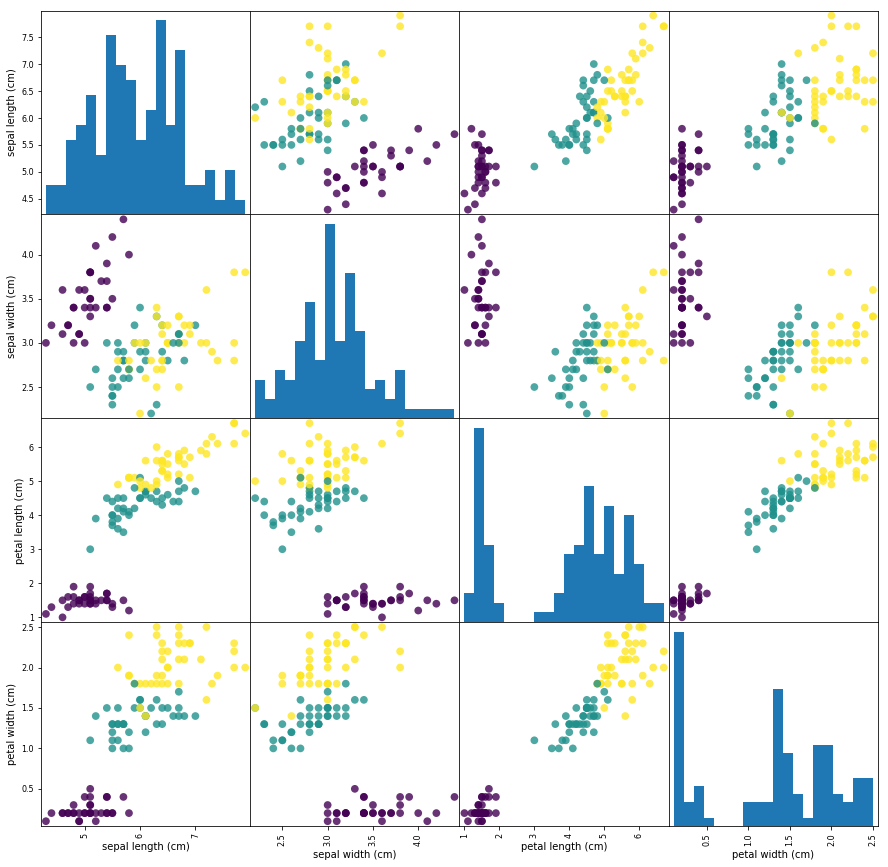

In [8]:
iris_dataframe = pd.DataFrame(X_train, columns=iris.feature_names)
grr = pd.plotting.scatter_matrix(iris_dataframe, c=y_train, figsize=(15, 15), marker='o',hist_kwds={'bins': 20}, s=60, alpha=.8)

This model is trained with a different method, instead of using all 4 features in the iris dataset, only 'petal length (cm)' and 'petal width (cm)' is used. This is designed to show how decision boundaries would look if it is applicable on a 2 dimensional scatter plot.

0.7894736842105263


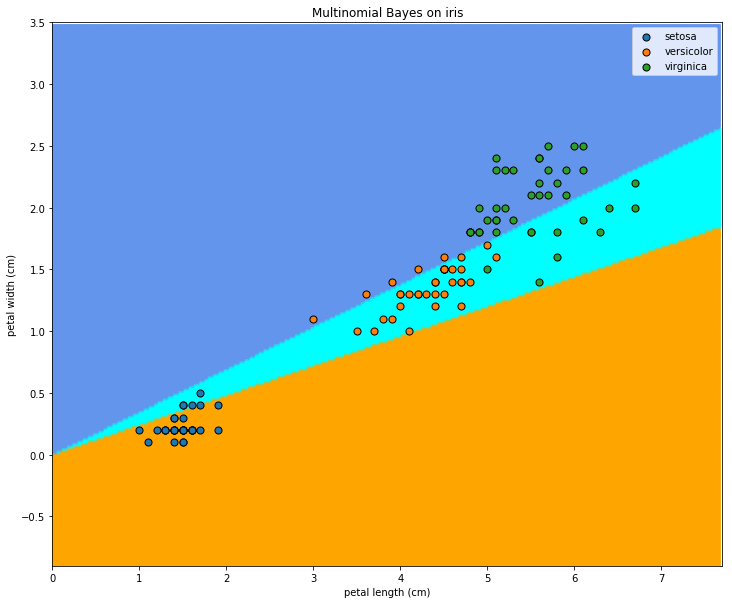

In [9]:
mnb2 = MultinomialNB(alpha=1)
mnb2.fit(X_train[:,2:], y_train)
labelsm2 = mnb2.predict(X_test[:,2:])
scorem2 = accuracy_score(labelsm2, y_test)
print(scorem2)
from matplotlib.colors import ListedColormap

x_min,x_max = X_train[:,2].min() - 1, X_train[:,2].max()+ 1
y_min,y_max = X_train[:,3].min() - 1, X_train[:,3].max()+ 1
h=0.02
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
Z = mnb2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_b = ListedColormap(['darkorange', 'c', 'darkblue'])
cmap_l = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
fig = plt.figure(figsize = (12,10))
ax1 = fig.add_subplot(111)
ax1.pcolormesh(xx, yy, Z, cmap=cmap_l, shading='gouraud')
for target in iris.target_names:
    index=np.where(iris.target_names==target)[0][0]
    ax1.scatter(X_train[:,2][y_train==index],X_train[:,3][y_train==index],
                cmap=cmap_b,edgecolor='k', s=50, label=target)
ax1.set_xlim(x_min,x_max)
ax1.set_ylim(y_min,y_max)
ax1.legend()
ax1.set_xlabel("petal length (cm)")
ax1.set_ylabel("petal width (cm)")
ax1.set_title("Multinomial Bayes on iris")
plt.show()

SMS Spam Collection v. 1

"The SMS Spam Collection v.1 is a public set of SMS labeled messages that have been collected for mobile phone spam research. It has one collection composed by 5,574 English, real and non-enconded messages, tagged according being legitimate (ham) or spam."
Almeida, T.A., Gómez Hidalgo, J.M. https://www.dt.fee.unicamp.br/%7Etiago/smsspamcollection/ 2011

text dataset. Multinomial and Bernoulli both trained and tested.

In [10]:
path = 'data/sms.tsv'
features = ['label', 'message']
sms = pd.read_table(path, header=None, names=features)
print(sms.shape)
print(sms.head())
print(sms.label.value_counts())
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})
X = sms.message
y = sms.label_num
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

(5572, 2)
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
ham     4825
spam     747
Name: label, dtype: int64


C:\Users\slm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until


Training times, test times and test accuracy for Multinomial NB and BernoulliNB on SMS Spam Collection v.1 Dataset

In [22]:
modelm = MultinomialNB(alpha=1)
modelb = BernoulliNB(alpha=1, binarize=1)
print("Multinomial NB: ")
t0 = time()
modelm.fit(X_train_dtm, y_train)
t_train_m = time() - t0
print("Training Time: %0.3fs" % t_train_m)

t0 = time()
predm = modelm.predict(X_test_dtm)
t_test_m = time() - t0
print("Test Time:  %0.3fs" % t_test_m)

scorem = accuracy_score(predm, y_test)
print("Accuracy:   %0.3f" % scorem)
print("Multinomial NB Classifier report: \n\n", classification_report(y_test, predm))
print("-------")
print("Bernoulli NB: ")
t0 = time()
modelb.fit(X_train_dtm, y_train)
t_train_b = time() - t0
print("Train Time: %0.3fs" % t_train_b)

t0 = time()
predb = modelb.predict(X_test_dtm)
t_test_b = time() - t0
print("Test Time:  %0.3fs" % t_test_b)

scoreb = accuracy_score(predb, y_test)
print("Accuracy:   %0.3f" % scoreb)
print("Bernoulli NB Classifier report: \n\n", classification_report(y_test, predb))

Multinomial NB: 
Training Time: 0.002s
Test Time:  0.000s
Accuracy:   0.982
Multinomial NB Classifier report: 

               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1208
           1       0.92      0.95      0.93       185

   micro avg       0.98      0.98      0.98      1393
   macro avg       0.96      0.97      0.96      1393
weighted avg       0.98      0.98      0.98      1393

-------
Bernoulli NB: 
Train Time: 0.003s
Test Time:  0.001s
Accuracy:   0.985
Bernoulli NB Classifier report: 

               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1208
           1       0.99      0.90      0.94       185

   micro avg       0.98      0.98      0.98      1393
   macro avg       0.99      0.95      0.97      1393
weighted avg       0.98      0.98      0.98      1393



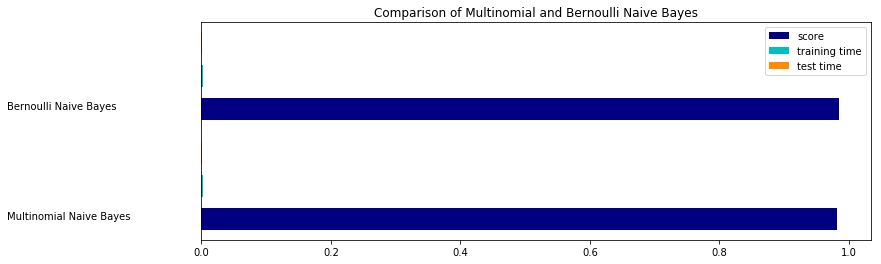

In [12]:
train_time = [t_train_m, t_train_b]
test_time = [t_test_m, t_test_b]
score = [scorem, scoreb]
compare_plot(score, train_time, test_time)

Each unique category name is numbered and then used as a target. Each text that represent features vectorized by CountVectorizer function by sklearn. Then the data is split to train and test data by employing the train_test_split function by sklearn. 

Training times, test times and test accuracy for Multinomial NB and BernoulliNB on News Category Dataset

k-fold cross validation applied with both Multinomial and Bernoulli Naive Bayes models on SMS Spam Collection v.1 Dataset and News Category Dataset. Accuracies for each fold and mean accuracies of k-fold cross validation is shown with the outputs.

In [13]:
X = sms.message
y = sms.label_num
aa = kFold(X, y, 5)
print("5-fold cross validation on Multinomial NB on sms dataset")
printscores(crossval(MultinomialNB(alpha=1),aa, 5))
print("------------")
print("5-fold cross validation on Bernoulli NB on sms dataset")
printscores(crossval(BernoulliNB(alpha=1),aa, 5))

5-fold cross validation on Multinomial NB on sms dataset
Accuracy: 0.980269
Accuracy: 0.981166
Accuracy: 0.975785
Accuracy: 0.976682
Accuracy: 0.977578
Mean Accuracy of k-fold cross validation: 0.978296
------------
5-fold cross validation on Bernoulli NB on sms dataset
Accuracy: 0.979372
Accuracy: 0.980269
Accuracy: 0.974888
Accuracy: 0.975785
Accuracy: 0.979372
Mean Accuracy of k-fold cross validation: 0.977937


20 News Groups Dataset

text dataset.
Bernoulli and Multinomial are trained and tested on this dataset.

In [14]:
data = fetch_20newsgroups()
#data.target_names
categories = data.target_names
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)
#print(train.data[5])

modelm = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=1.0))
modelb = make_pipeline(TfidfVectorizer(), BernoulliNB(alpha=1.0, binarize=1.0))
modelm.fit(train.data, train.target)
modelb.fit(train.data, train.target)
labelsm = modelm.predict(test.data)
labelsb = modelb.predict(test.data)

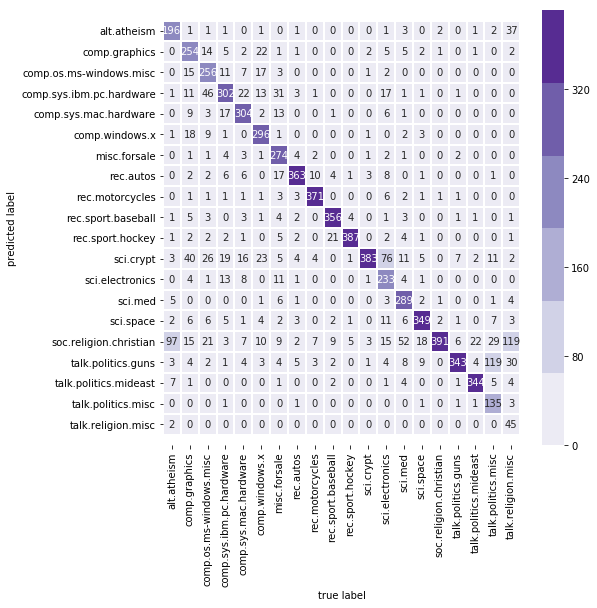

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labelsm)
colormap = sns.color_palette("Purples")
ax = sns.heatmap(mat.T, annot=True, fmt='d', cbar=True, linewidths=1, cmap=colormap, 
            xticklabels=train.target_names, yticklabels=train.target_names)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [21]:
print("Train accuracy of Multinomial NB = %0.5f" % modelm.score(train.data, train.target))
print("Test accuracy of Multinomial NB = %0.5f" % modelm.score(test.data, test.target))
print("Train accuracy of Bernoulli NB = %0.5f" % modelb.score(train.data, train.target))
print("Test accuracy of Bernoulli NB = %0.5f" % modelb.score(test.data, test.target))
print("Training of Multinomial NB: ")
t0 = time()
modelm.fit(train.data, train.target)
t_train_m = time() - t0
print("Training Time: %0.3fs" % t_train_m)

t0 = time()
predm = modelm.predict(test.data)
t_test_m = time() - t0
print("Test Time:  %0.3fs" % t_test_m)

scorem = accuracy_score(test.target, predm)
print("Accuracy:   %0.3f" % scorem)
print("Multinomial NB Classifier report: \n\n", classification_report(test.target, predm))
print("-------")
print("Training of Bernoulli: ")
t0 = time()
modelb.fit(train.data, train.target)
t_train_b = time() - t0
print("Train Time: %0.3fs" % t_train_b)

t0 = time()
predb = modelb.predict(test.data)
t_test_b = time() - t0
print("Test Time:  %0.3fs" % t_test_b)

scoreb = accuracy_score(test.target, predb)
print("Accuracy:   %0.3f" % scoreb)
print("Bernoulli NB Classifier report: \n\n", classification_report(test.target, predb))

Train accuracy of Multinomial NB = 0.93928
Test accuracy of Multinomial NB = 0.77947
Train accuracy of Bernoulli NB = 0.53244
Test accuracy of Bernoulli NB = 0.39445
Training of Multinomial NB: 
Training Time: 2.802s
Test Time:  1.532s
Accuracy:   0.779
Multinomial NB Classifier report: 

               precision    recall  f1-score   support

           0       0.79      0.61      0.69       319
           1       0.80      0.65      0.72       389
           2       0.82      0.65      0.73       394
           3       0.67      0.77      0.72       392
           4       0.85      0.79      0.82       385
           5       0.89      0.75      0.81       395
           6       0.93      0.70      0.80       390
           7       0.86      0.92      0.89       396
           8       0.94      0.93      0.94       398
           9       0.92      0.90      0.91       397
          10       0.90      0.97      0.93       399
          11       0.60      0.97      0.74       396
      

C:\Users\slm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\slm\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


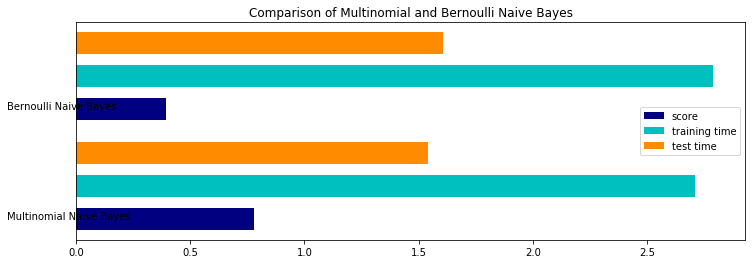

In [17]:
indices = np.arange(2)
clf_names = ["Multinomial Naive Bayes", "Bernoulli Naive Bayes"]
train_time = [t_train_m, t_train_b]
test_time = [t_test_m, t_test_b]
score = [scorem, scoreb]

plt.figure(figsize=(12, 4))
plt.title("Comparison of Multinomial and Bernoulli Naive Bayes")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, train_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()